# On Parcels
> An introductory article to Cryptovoxels' Parcel Data

- toc: true
- filename: Parcels
- tab: CVMinigames | Parcels
- title: CVMinigames
- template: article
- description: this isnt working
- image: images/company_logo.png
- keywords: thisworks
- badges: true
- comments: true
- categories: [test]
- hide: false
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

I love freebies. In my opinion, guestbooks are the ticket to a bunch of em!

So what's the best way to find em all?

Perhaps the same way to find out a lot of really cool information... 🤔

## Parcel Data

In [ ]:
#hide 
!pip install matplotlib
!pip install geopandas
!pip install folium
!pip install requests

For starters CV provides generic data on ALL their [parcels](https://www.cryptovoxels.com/api/parcels/search.json)

In [6]:
#hide 
import requests
import json
url = 'https://www.cryptovoxels.com/api/parcels/search.json'
r = requests.get(url)
data = json.loads(r.text)['parcels'] 

In [11]:
#hide 
import pandas as pd
import geopandas as gpd
gdf = { "type": "FeatureCollection", "features": [] }
for obj in data:
  feat = { "type": "Feature", "geometry": { "type": "Polygon", "coordinates": [ ] }, "properties": { } }
  feat['geometry']['coordinates'] = obj['geometry']['coordinates'] 
  feat['properties'] = {key: obj[key] for key in obj if key not in ['x1','x2','y1','y2','z1','z2','geometry']}
  gdf['features'].append(feat)  

# What fresh hell have I done here?
with open('../data/cv.geojson', 'w') as outfile: json.dump(gdf, outfile)
  
gdf = gpd.read_file('../data/cv.geojson')
gdf['id'] = gdf.id.astype(str) 
gdf['vol'] = gdf['area'] * gdf['height'] 
gdf['max_vol'] = gdf['area'] * ( gdf['height'] + 5) 
gdf.to_file("../data/cv.geojson", driver='GeoJSON')

ModuleNotFoundError: No module named 'geopandas'

#hide 
import folium
import branca
import branca.colormap as cm
from branca.colormap import linear

In [33]:
#hide 
# https://stackoverflow.com/questions/54595931/show-different-pop-ups-for-different-polygons-in-a-geojson-folium-python-ma 
# https://python-visualization.github.io/branca/colormap.html 

mymap = folium.Map(location=[0,0], tiles = 'https://map.cryptovoxels.com/tile?z={z}&x={x}&y={y}', attr="Map data &copy; Cryptovoxels", zoom_start=10, control_scale=True) 
colormap = cm.LinearColormap(colors=['white', 'blue','green', 'yellow', 'orange', 'red'], caption="Parcel Volume").to_step(data=gdf['vol'], method='quant', quantiles=[0,0.25,0.5,0.75,0.98, 0.999, 0.9999,1]) 
style_function = lambda x: {"weight":0.5, 'color':'black', 'fillColor':colormap(x['properties']['vol']), 'fillOpacity':0.75} 
highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1} 

layer = folium.FeatureGroup(name='Volume', show=False) 
temp_geojson = folium.GeoJson(gdf) 
for feature in temp_geojson.data['features']: 
    innerHTML = '<b>VOLUME</b><br>' 
    innerHTML += '<b>'+str(feature['properties']['island'])+' - '+str(feature['properties']['suburb']) + '</b><br>' 
    innerHTML += '<b> Name - ' +str(feature['properties']['name']) + '</b><br>' 
    innerHTML += '<b> Address - ' +str(feature['properties']['address']) + '</b><br>' 
    innerHTML += '<b> Height - ' +str(feature['properties']['height']) + '</b><br>' 
    innerHTML += '<b> Area - ' +str(feature['properties']['area']) + '</b><br>' 
    innerHTML += '<b> Volume: AreaxHeight - ' +str(feature['properties']['vol']) + '</b><br>' 
    innerHTML += '<b> Max Volume: AreaX(Height+5) - ' +str(feature['properties']['max_vol']) + '</b><br>' 
    foo = lambda txt, source: f"<div id='popupIFrame' style='white-space: nowrap;' align='center''> <a href='{source}'> Visit </a><br>{txt}</div>"
    innerTxt = foo(innerHTML, f'https://www.cryptovoxels.com/parcels/{feature["properties"]["id"]}')
    temp_layer = folium.GeoJson(feature, style_function=style_function, highlight_function=highlight_function, tooltip=innerTxt) 
    folium.Popup( html=innerTxt ).add_to(temp_layer) 
    temp_layer.add_to(layer) 

layer.add_to(mymap) 
colormap.add_to(mymap) 
mymap.save('../docs/maps/cv_vol_map.html') 

In [34]:
#hide 
# df = gdf[gdf['island'] == 'Scarcity'] # Only Scarcity Island 
# gdf[gdf['island']=='Scarcity']['island'].describe()
# gdf[gdf['island']=='Scarcity'].plot()

The data contains geocoordinates and a bit of meta data which can let us do fun stuff like this <a href="https://cvminigames.com/blog/docs/maps/cv_vol_map.html"> map </a>.

Where: 
- Color depicts volume broke out by quartile.

- And the top largest 2% and 1% of parcels painted orange and red, respectively.

In [35]:
%%html
<iframe height='500px' width='1000px' src="https://cvminigames.com/blog/docs/maps/cv_vol_map.html"> </iframe>

We can do other things. 

Here is a frequency plot of Flora Islands Volume (excluding it's outlier)

<AxesSubplot:ylabel='Frequency'>

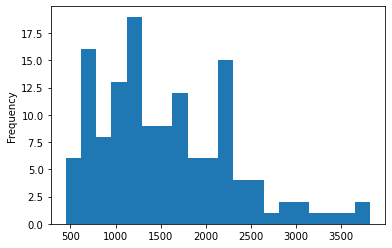

In [36]:
#hide_input 
t = gdf[gdf['island']=='Flora']
q_low = t["vol"].quantile(0.01)
q_hi  = t["vol"].quantile(0.99)
t = t[(t["vol"] < q_hi) & (t["vol"] > q_low)]
t['vol'].plot.hist(bins=20)

Ok. So thats nice...

I'll do more exploration on this end some time later...

What else can we do?

## Filtering Parcels

Information about a specific parcel is available by adding it's parcel # to the end of the following url: https://www.cryptovoxels.com/api/parcels/  

This data can then be filtered en-mass to search for certain properties, or inspected individually.

In [37]:
#hide 
t = """
# This code will save each parcel features data
import requests
import json 
errors = []
for index, row in gdf.iterrows():
  url = 'https://www.cryptovoxels.com/api/parcels/'+str(row['id'])+'.json' 
  r = requests.get(url)
  if r.status_code == 404: errors.push(str(row['id'])); print('error', str(row['id'])); continue
  data = json.loads(r.text) 
  with open('../data/parcels/'+str(row['id'])+'.json', 'w') as file:
    json.dump(data, file)
"""

In [38]:
#hide 
import json
from shapely.geometry import Polygon
from os.path import exists
pd.options.display.max_colwidth = 500
deets = [] 

for index, row in gdf.iterrows():  
  url = '../data/parcels/'+str(row['id'])+'.json' 
  if not exists(url): print('noexisst', str(row['id'])); continue
  data = ''  
  with open(url, 'r') as j: data = json.loads(j.read())['parcel'] 
  flag = False
  if data['content'] == None: flag = True 
  elif 'features' not in data['content']: flag = True
  newobj = {key: data[key] for key in data if key in ['id', 'x1','x2','y1','y2','z1','z2', 'traffic_visits','contributors','description', 'sandbox', 'lightmap_status', 'kind']} 
  if flag: newobj['built'] = 0; newobj['book'] = 0
  else:
    newobj['built'] = 1
    guestbook = list(filter(lambda x: x['type'] == 'guest-book', data['content']['features'])) 
    newobj['book'] = 1 if guestbook else  0 
  deets.append( newobj )


noexisst 7026
noexisst 7025
noexisst 7024
noexisst 7023
noexisst 7022
noexisst 7021
noexisst 7020
noexisst 7019
noexisst 7018
noexisst 7017
noexisst 7016
noexisst 7015
noexisst 7014
noexisst 7013
noexisst 7012
noexisst 7011
noexisst 7010
noexisst 7009
noexisst 7008
noexisst 7007
noexisst 7006
noexisst 7005
noexisst 7004
noexisst 7003
noexisst 7002
noexisst 7001
noexisst 7000
noexisst 6999
noexisst 6998
noexisst 6997
noexisst 6996
noexisst 6995
noexisst 6994
noexisst 6993
noexisst 6992
noexisst 6991
noexisst 6990
noexisst 6989
noexisst 6988
noexisst 6987
noexisst 6986
noexisst 6985
noexisst 6984
noexisst 6983
noexisst 6982
noexisst 6981
noexisst 6980
noexisst 6979
noexisst 6978
noexisst 6977
noexisst 6976
noexisst 6975
noexisst 6974
noexisst 6973
noexisst 6972
noexisst 6971
noexisst 6970
noexisst 6969
noexisst 6968
noexisst 6967
noexisst 6966
noexisst 6965
noexisst 6964
noexisst 6963
noexisst 6962
noexisst 6961
noexisst 6960
noexisst 6959
noexisst 6958
noexisst 6957
noexisst 6956
noexis

In [39]:
#hide 
book = pd.json_normalize(data=deets).convert_dtypes() 
book['contributors'] = book['contributors'].astype(str)
book['id'] = book['id'].astype(str) 
book['book'] = book['book'].astype(float) 
bookgdf = gpd.GeoDataFrame( pd.merge(gdf, book, on="id", how='left'), geometry='geometry', crs='epsg:3857') 

In [43]:
bookgdf.dtypes

id                   object
height                int64
address              object
suburb               object
island               object
name                 object
area                  int64
distance            float64
owner                object
owner_name           object
label                object
geometry           geometry
vol                   int64
max_vol               int64
traffic_visits        Int64
x1                    Int64
x2                    Int64
y1                    Int64
y2                    Int64
z1                    Int64
z2                    Int64
contributors         object
description          string
sandbox             boolean
lightmap_status      string
kind                 string
built                 Int64
book                float64
dtype: object

In [48]:
#hide 
import numpy as np
# https://stackoverflow.com/questions/54595931/show-different-pop-ups-for-different-polygons-in-a-geojson-folium-python-ma 
# https://python-visualization.github.io/branca/colormap.html 

mymap = folium.Map(location=[0,0], tiles = 'https://map.cryptovoxels.com/tile?z={z}&x={x}&y={y}', attr="Map data &copy; Cryptovoxels", zoom_start=10, control_scale=True) 
colormap = cm.LinearColormap(colors=['white', 'green'], caption="Guest Book Exists")
style_function = lambda x: {
    "weight":0.5, 'color':'black', 
    'fillColor': 'black' if pd.isnull([ x['properties']['book'] ]) else colormap(x['properties']['book']), 'fillOpacity':0.75
} 
highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1} 

In [49]:
#hide 
layer = folium.FeatureGroup(name='your layer name', show=False)
for feature in folium.GeoJson(bookgdf).data['features']: 
    innerHTML = f"<b>VOLUME</b><br> \
        <b>{str(feature['properties']['island'])} - {str(feature['properties']['suburb'])}</b><br> \
        <b> Name - { str(feature['properties']['name']) } </b><br> \
        <b> Address - { str(feature['properties']['address']) } </b><br> \
    "
    foo = lambda txt, source: f"<div id='popupIFrame' style='white-space: nowrap;' align='center''> <a href='{source}'> Visit </a><br>{txt}</div>"
    innerTxt = foo(innerHTML, f'https://www.cryptovoxels.com/parcels/{feature["properties"]["id"]}')
    temp_layer = folium.GeoJson(feature, style_function=style_function, highlight_function=highlight_function, tooltip=innerTxt) 
    folium.Popup( html=innerTxt ).add_to(temp_layer) 
    temp_layer.add_to(layer) 

layer.add_to(mymap) 
colormap.add_to(mymap) 
mymap.save('../docs/maps/cv_book_map.html') 

For example, here is a [map](https://cvminigames.com/blog/docs/maps/cv_book_map.html) of all the guestbooks!

In [50]:
%%html
<iframe height='500px' width='1000px' src="https://cvminigames.com/blog/docs/maps/cv_book_map.html" > </iframe>

There is an abundance of directions you can go with this information.

One nifty trick is to combine it with even more data!

This next [map](https://cvminigames.com/blog/docs/maps/cv_visitor_map.html) color codes using a parcels visitor data. 

This info was provided by our friends over at the [Metacat](https://www.metacat.world/topic/108) team.

In [56]:
#hide 
import pandas as pd
df90 = pd.read_csv("https://www.k1ic.com/traffic_archive/cv_all_parcel_90day_traffic.csv")
df90['parcel_id'] = df90['parcel_id'].astype(int)
bookgdf['id'] = bookgdf['id'].astype(int)
tdf = bookgdf.merge(df90, left_on='id', right_on='parcel_id', how='right')
tdf = tdf.sort_values(by=["90day_traffic_total"])
tdf['90day_traffic_total'] = tdf['90day_traffic_total'].fillna(0)

In [57]:
#hide 
# https://stackoverflow.com/questions/54595931/show-different-pop-ups-for-different-polygons-in-a-geojson-folium-python-ma
# https://python-visualization.github.io/branca/colormap.html

mymap = folium.Map(location=[0,0], tiles = 'https://map.cryptovoxels.com/tile?z={z}&x={x}&y={y}', attr="Map data &copy; Cryptovoxels", zoom_start=10, control_scale=True)
colormap = cm.LinearColormap(
    colors=['white','blue','black', 'red', 'green'], 
    caption="90day_traffic_total",
    vmin= 0,
    vmax= 10000
) #.to_step(data=tdf['90day_traffic_total'], method='quant', n=6)
style_function = lambda x: {"weight":0.5, 'color':'black', 'fillColor':colormap(x['properties']['90day_traffic_total']), 'fillOpacity':0.75}
highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1}

layer = folium.FeatureGroup(name='your layer name', show=False)
temp_geojson = folium.GeoJson('cv_map.geojson')
for feature in temp_geojson.data['features']:  
    innerHTML = '<b>'+str(feature['properties']['island'])+' - '+str(feature['properties']['suburb']) + '</b><br>'
    innerHTML += '<b> Address - ' +str(feature['properties']['address']) + '</b><br>'
    innerHTML += '<b> 90 Day Traffic - ' +str(feature['properties']['90day_traffic_total']) + '</b><br>'
    temp_layer = folium.GeoJson(feature, style_function=style_function, highlight_function=highlight_function, tooltip=innerHTML) 
    foo = lambda name, source: f""" <a id="popupIFrame" width="600" height="200" align="center" href="{source}"> {name} </a> """
    folium.Popup( html=foo(feature["properties"]["address"], f'www.cryptovoxels.com/parcels/{feature["properties"]["id"]}') ).add_to(temp_layer)
    temp_layer.add_to(layer)

layer.add_to(mymap)
colormap.add_to(mymap) 

In [58]:
#hide <No longer using this! 
# mymap.save('../docs/maps/cv_visitor_map.html') 

In [59]:
%%html
<iframe height='500px' width='1000px' src="https://cvminigames.com/blog/docs/maps/cv_visitor_map.html"> </iframe>

In the end, all this freely available data allows for some pretty cool inspection.

Here is a look at the data we have gathered along the way: 

In [61]:
ls

000_core.ipynb        003_Progress.ipynb    999_Legal.ipynb
001a_core_test.ipynb  004_Scarcity.ipynb    Scarcity.ipynb
001b_core_test.ipynb  005_Technology.ipynb  _devserver.ipynb
001c_Example.ipynb    006_Tutorials.ipynb   cv_map.geojson
002_Parcels.ipynb     013_CV_Misc.ipynb     index.ipynb


In [60]:
#hide 
tdf.sort_values(by='90day_traffic_total').head(1)

,id,height,address,suburb,island,name,area,distance,owner,owner_name,...,z2,contributors,description,sandbox,lightmap_status,kind,built,book,parcel_id,90day_traffic_total
5025,5027,12,3 Cryptography Fork,Test Island,Test Island,None,40,4183.130168,0x2d891ed45c4c3eab978513df4b92a35cf131d2e2,bnolan,...,41,None,<NA>,False,None,plot,1,0.0,5027,0


In [63]:
tdf.to_file("../data/cv.geojson", driver='GeoJSON')

The final geojson dataset will live [here](https://cvminigames.com/blog/data/cv.geojson).